In [8]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [9]:
# Divide the annotation file into multiple .txt files for each image
# Define the paths
annotation_path = "./grocery_annotations/annotation.txt"
image_dir = "./Images_Grocery/ShelfImages/"

# Open the annotation file
with open(annotation_path, 'r') as f:
    lines = f.readlines()

# Process each line
for line in lines:
    parts = line.split()
    image_name = parts[0]
    num_objects = int(parts[1])
    objects = [parts[i:i+5] for i in range(2, len(parts), 5)]

    # Create a new annotation file for this image
    with open(os.path.join(image_dir, image_name + '.txt'), 'w') as f:
        for obj in objects:
            # Write the object annotation to the file
            f.write(' '.join(obj) + '\n')

In [10]:
from sklearn.model_selection import train_test_split

def list_files(full_data_path = "./Images_Grocery/ShelfImages/", image_ext = '.JPG', test_size = 0.15, validation_size = 0.15):

    files = []

    for r, d, f in os.walk(full_data_path):
        for file in f:
            if file.endswith(image_ext):
                files.append(file)

    # Split the data into training and testing
    train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

    # Split the training data into training and validation
    train_files, val_files = train_test_split(train_files, test_size=validation_size, random_state=42)

    return train_files, val_files, test_files

In [11]:
training_files, validation_files, test_files = list_files()

print(str(len(training_files)) + " training files")
print(str(len(validation_files)) + " validation files")
print(str(len(test_files)) + " test files")

255 training files
45 validation files
53 test files


In [22]:
input_size = 244
new_size = (244, 244)  # New size (height, width)

def resize_image_and_box(img, box):
    # Calculate the scale factors
    y_scale = input_size / img.shape[0]
    x_scale = input_size / img.shape[1]

    # Resize the image
    resized_img = cv2.resize(img, new_size)

    x, y, w, h = box[0], box[1], box[2], box[3]
    #new_box = [int(x / r), int(y / r), int(w / r), int(h / r)]
    
    # Scale the bounding box coordinates
    resized_box = [int(box[0] * x_scale), int(box[1] * y_scale), int(box[2] * x_scale), int(box[3] * y_scale)]

    return resized_img, resized_box

def format_image(img1, box1):
    img = img1.copy()
    box = box1.copy()
    height, width = img.shape
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv2.resize(img, new_size, interpolation= cv2.INTER_AREA)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int(x / r), int(y / r), int(w / r), int(h / r)]
    
    return new_image, new_box

In [23]:
class CustomDataset(Dataset):
    def __init__(self, images_folder, transform=None):
        self.dataset = self.create_dataset(images_folder)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        entry = self.dataset[idx]

        # If you want to apply any image transformations
        if self.transform:
            entry["image"] = self.transform(entry["image"])

        # Convert to PyTorch tensor
        image = transforms.ToTensor()(entry["image"])

        # Convert bounding boxes and class labels to tensors
        bounding_boxes = torch.tensor(entry["bounding_boxes"], dtype=torch.float32)
        class_labels = torch.tensor(entry["class_label"], dtype=torch.int64)

        # Create target dictionary
        target = {
            'boxes': bounding_boxes,
            'labels': class_labels
        }

        return image, target
    
    def create_dataset(self, files, full_data_path = "./Images_Grocery/ShelfImages/"):
        dataset = []
        
        for file in files:
            # Load the image in grayscale
            img = cv2.imread(os.path.join(full_data_path, file), cv2.IMREAD_GRAYSCALE)
            k = 1
            labels = []
            with open(os.path.join(full_data_path, file + ".txt"), 'r') as fp:
                lines = fp.readlines()
                boxes = []
                for line in lines:
                    parts = line.split()
                    box = np.array(parts[:4], dtype=float)
                    copy_img, box = format_image(img, box)
                    copy_img = copy_img.astype(float) / 255.
                    boxes.append(box)
                    labels.append(k)
                    
                dataset.append({
                    "image": copy_img,
                    "bounding_boxes": boxes,
                    "class_label": labels
                })

        return dataset


custom_dataset = CustomDataset(training_files)

# Example: Using DataLoader
dataloader = DataLoader(custom_dataset, batch_size=1, shuffle=True, num_workers=0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


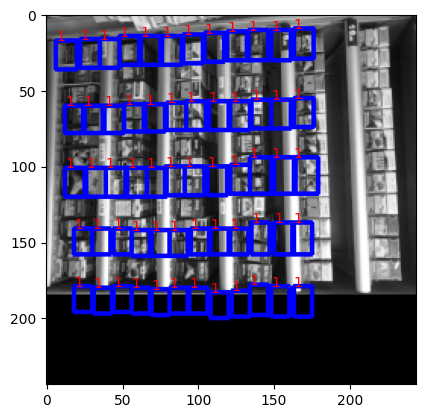

In [38]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Get the first batch from the dataloader
first_batch = next(iter(dataloader))

# Get the first image, bounding boxes, and labels from the batch
images = first_batch[0]
targets = first_batch[1]
#class_labels = first_batch['class_label']

# Convert the image tensor to a numpy array and transpose the dimensions for matplotlib
image = images[0].squeeze(0).squeeze(0)

# Convert the image to float32
image = image.numpy().astype(np.float32)

# Convert the grayscale image to RGB
temp_color_img = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# Get the first bounding box and convert it to numpy
boxes = targets['boxes'][0].numpy()
labels = targets['labels'][0].numpy()
for box, label in zip(boxes, labels):
    x, y, w, h = int(box[0]),int(box[1]), int(box[2]), int(box[3])
    cv2.rectangle(temp_color_img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    plt.text(x, y, str(label), color='red')
plt.imshow(temp_color_img)